In [1]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [2]:
in_dir = 'D:/monai-project/Data_Train_Test'
model_dir = 'D:/monai-project/results'

In [3]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

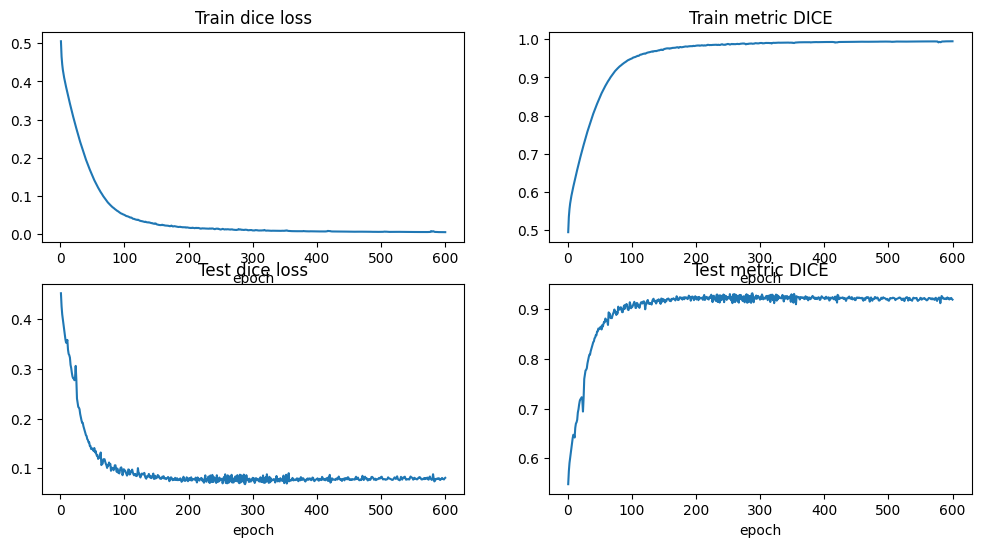

In [4]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [11]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[20:23]

In [12]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

d:\monai-project\.venv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [13]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [14]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [15]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


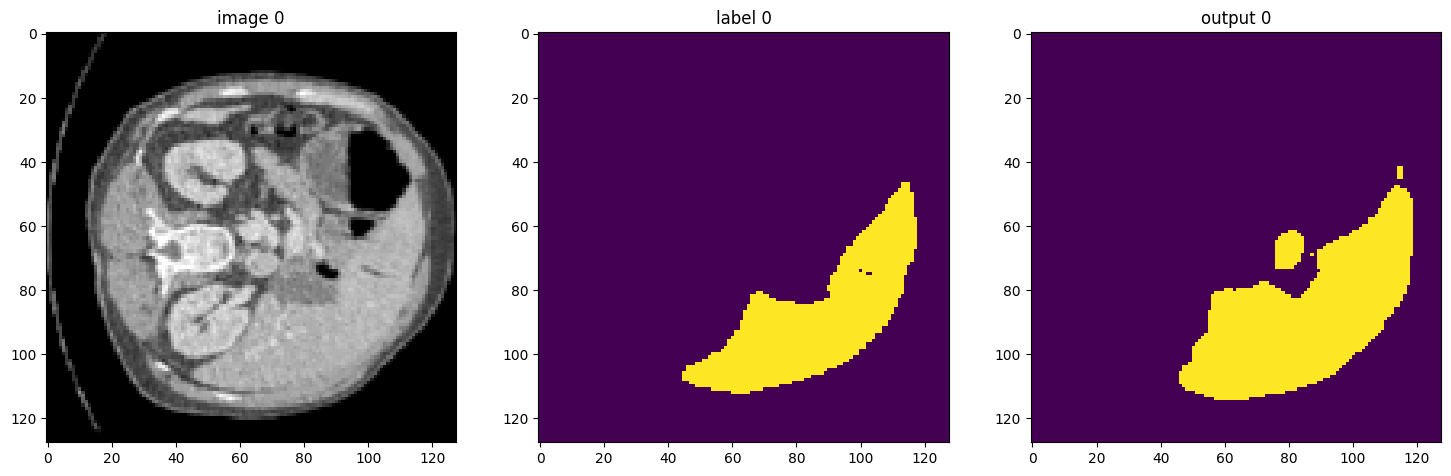

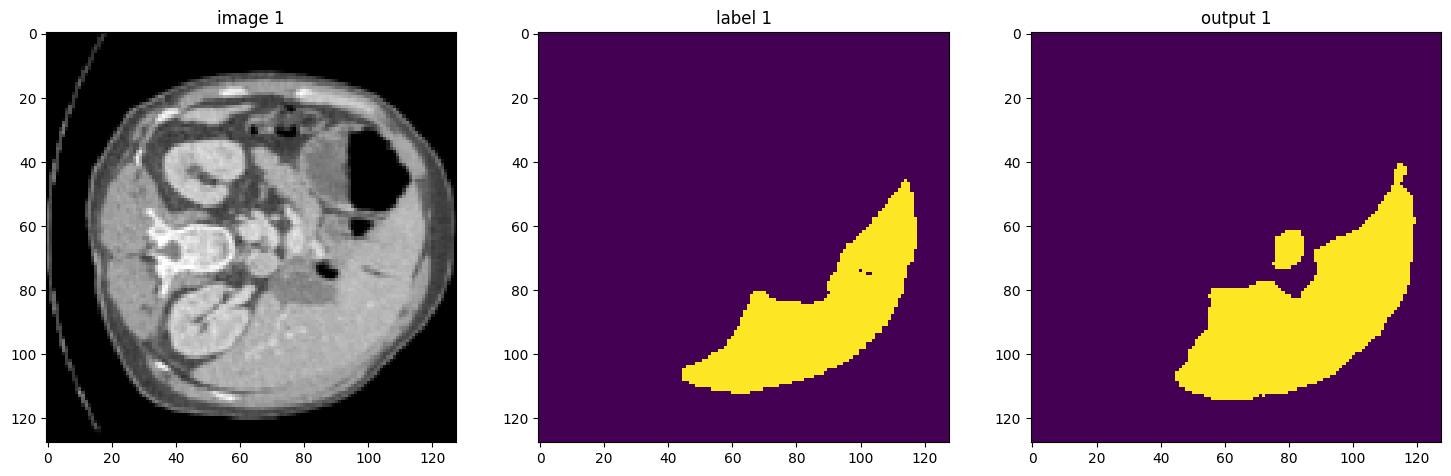

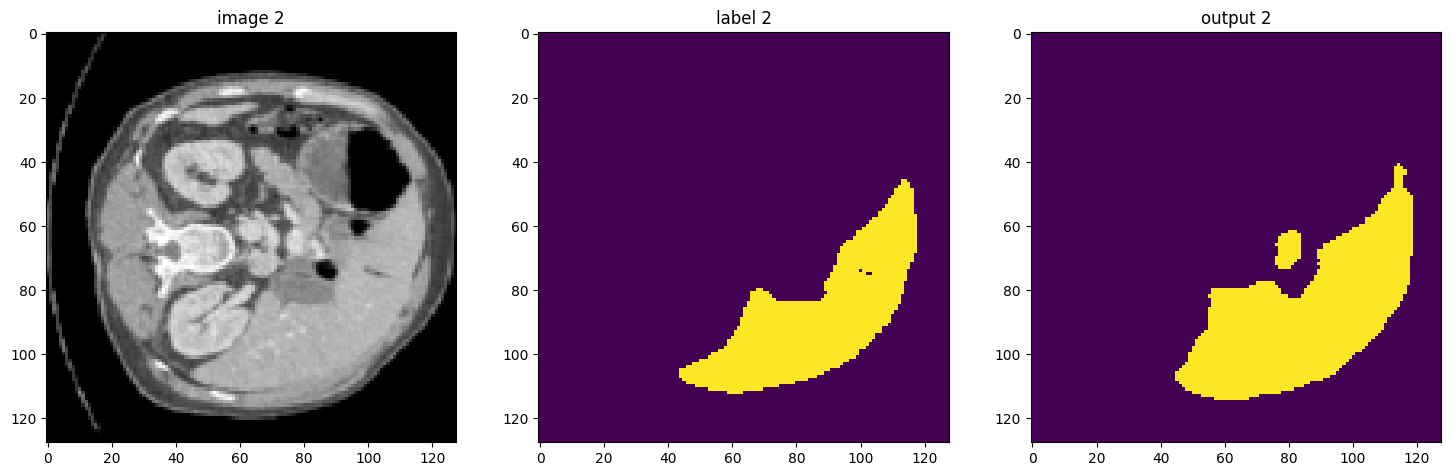

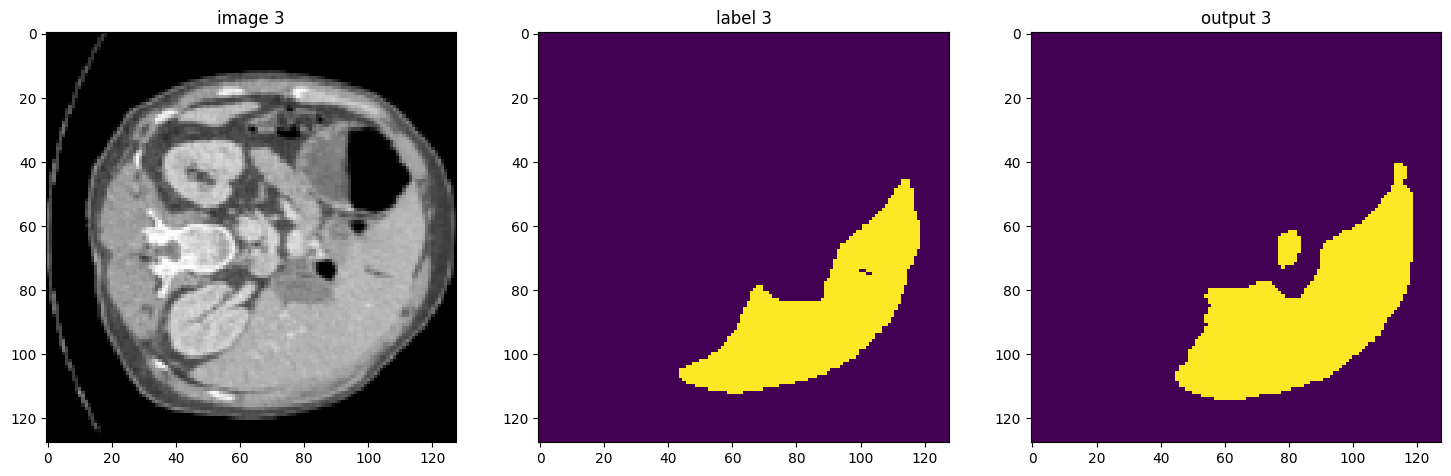

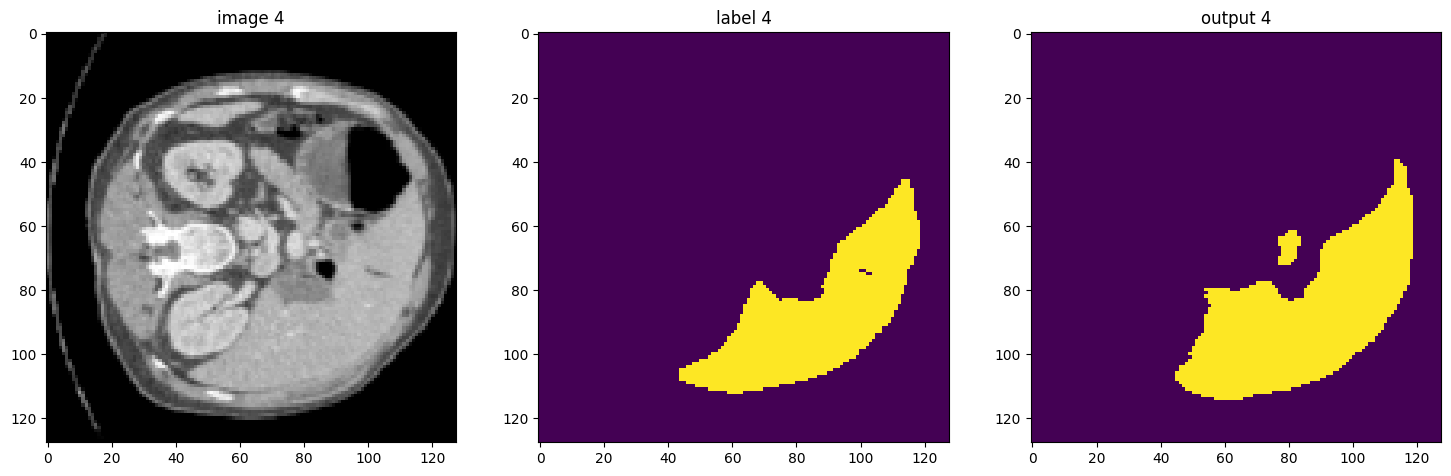

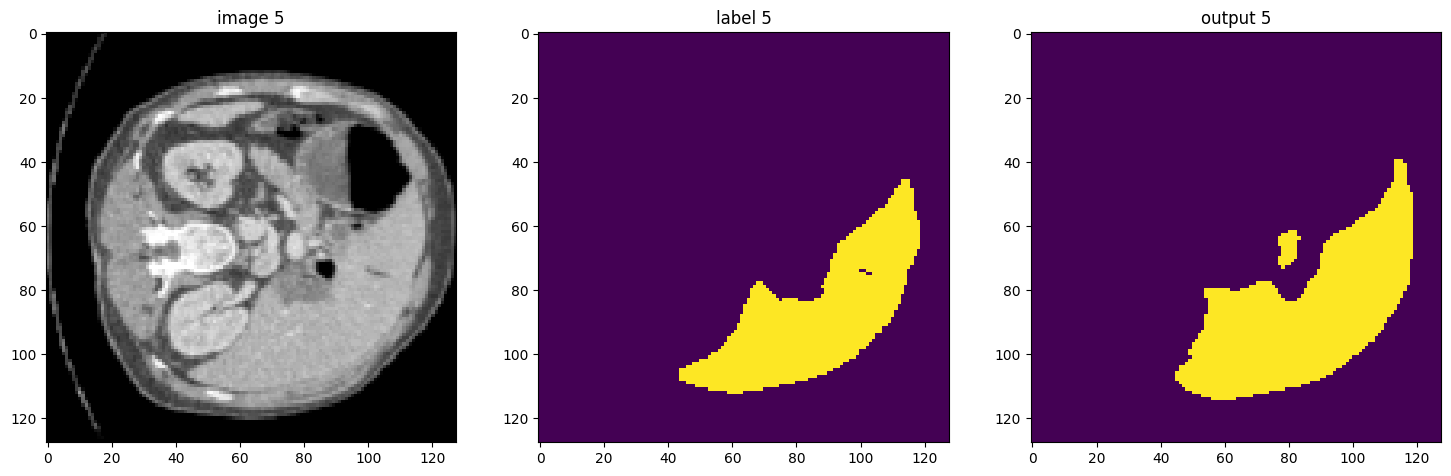

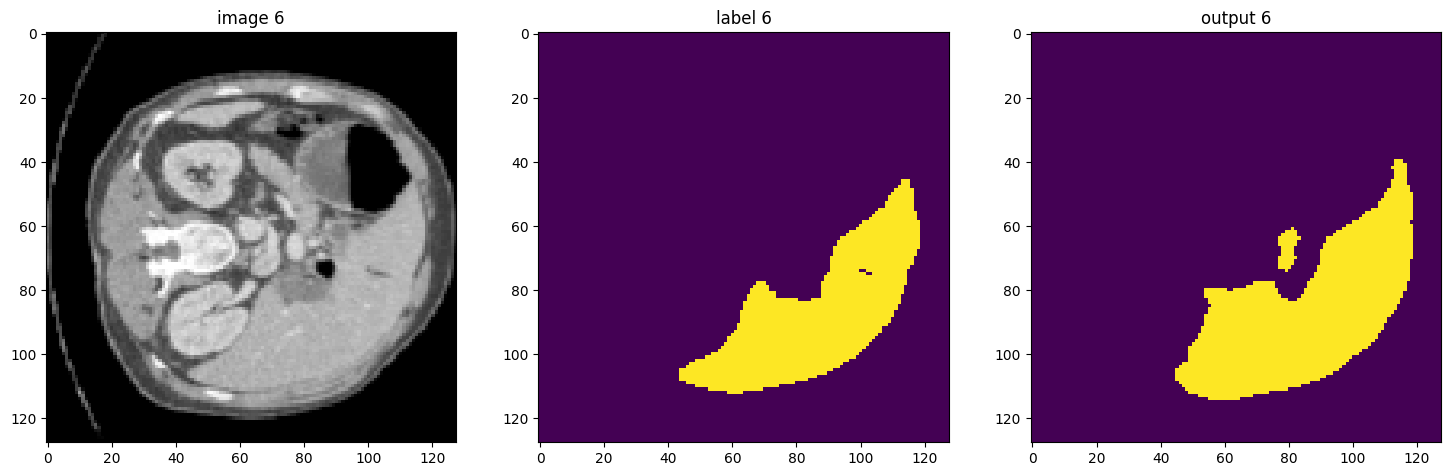

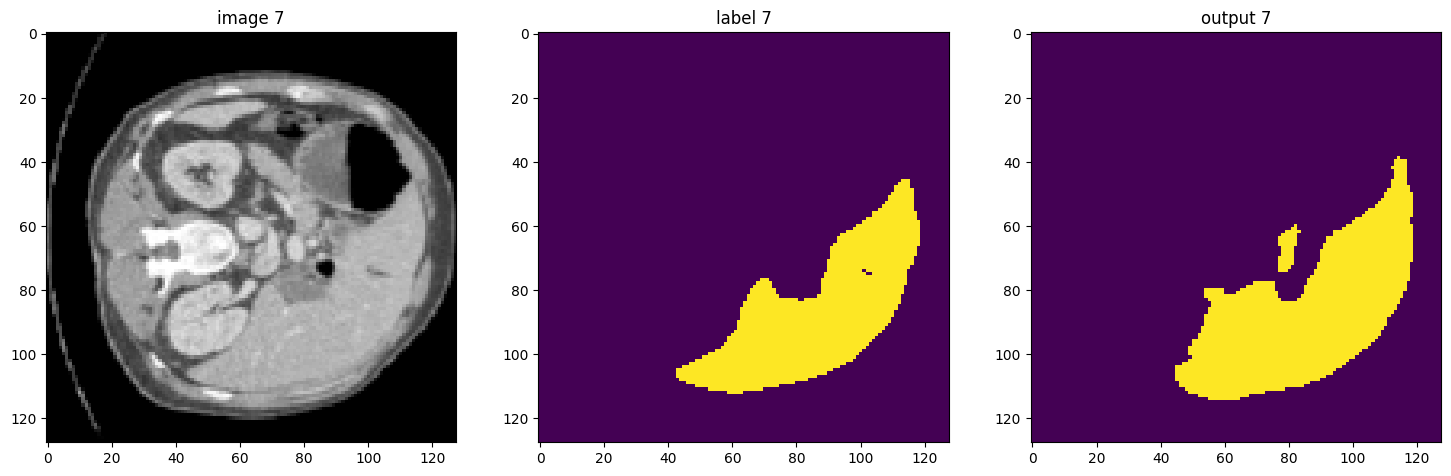

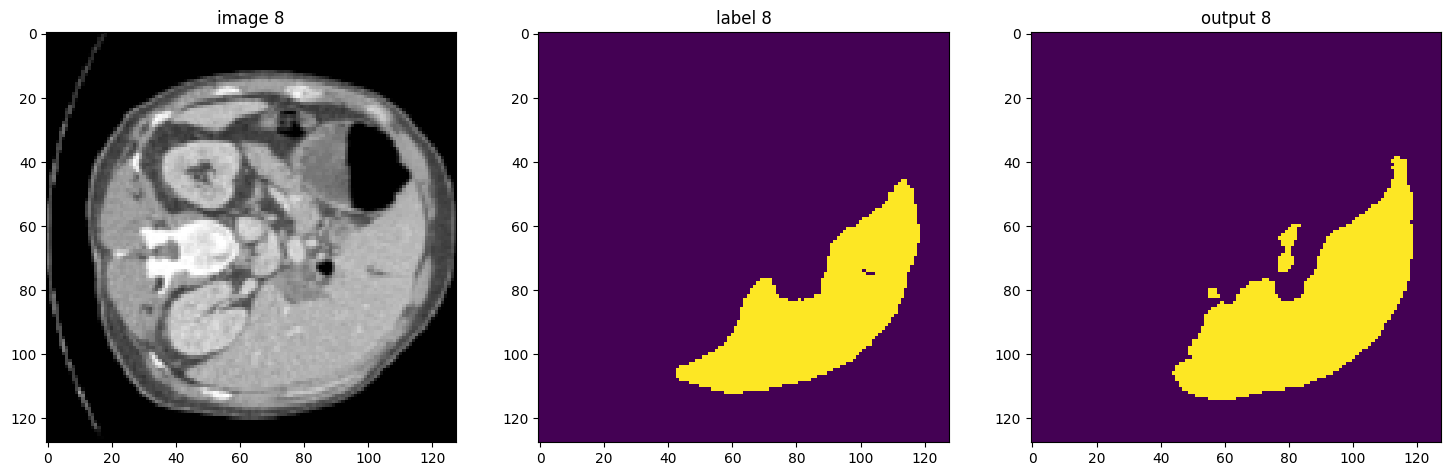

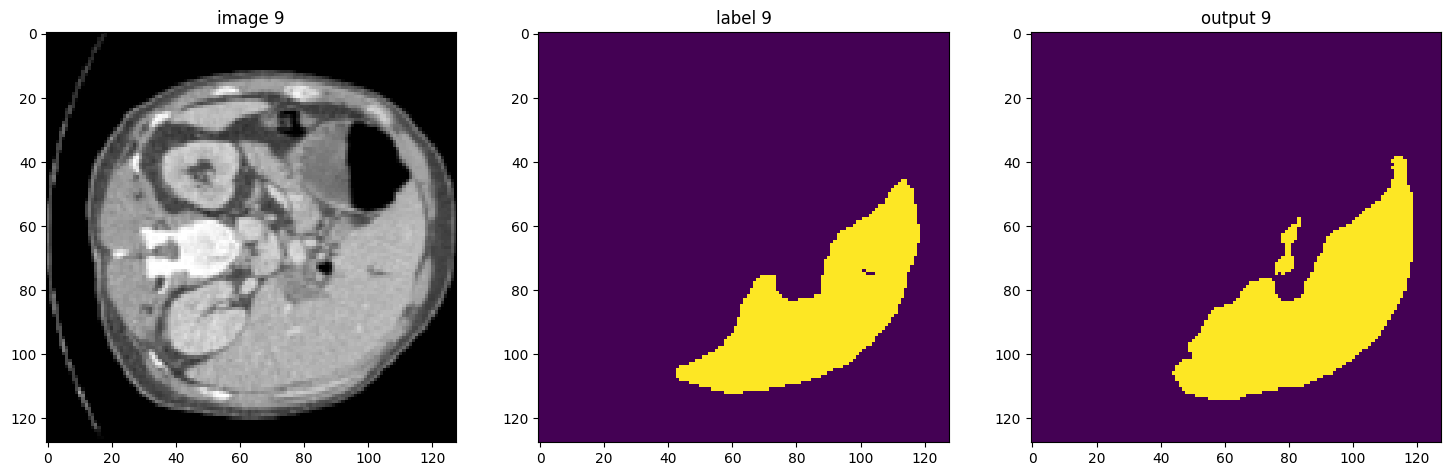

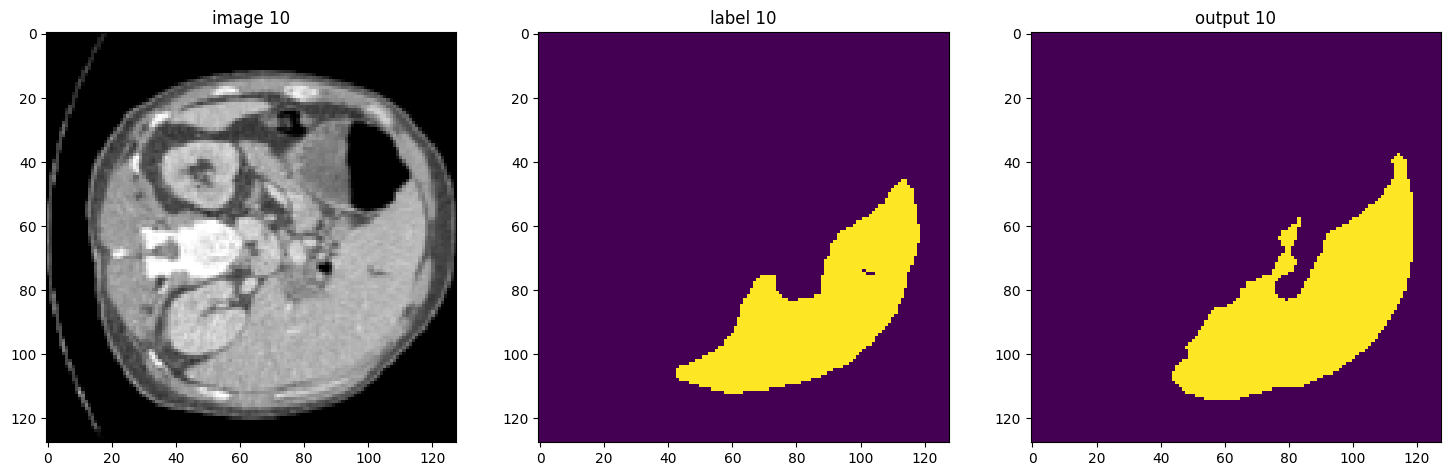

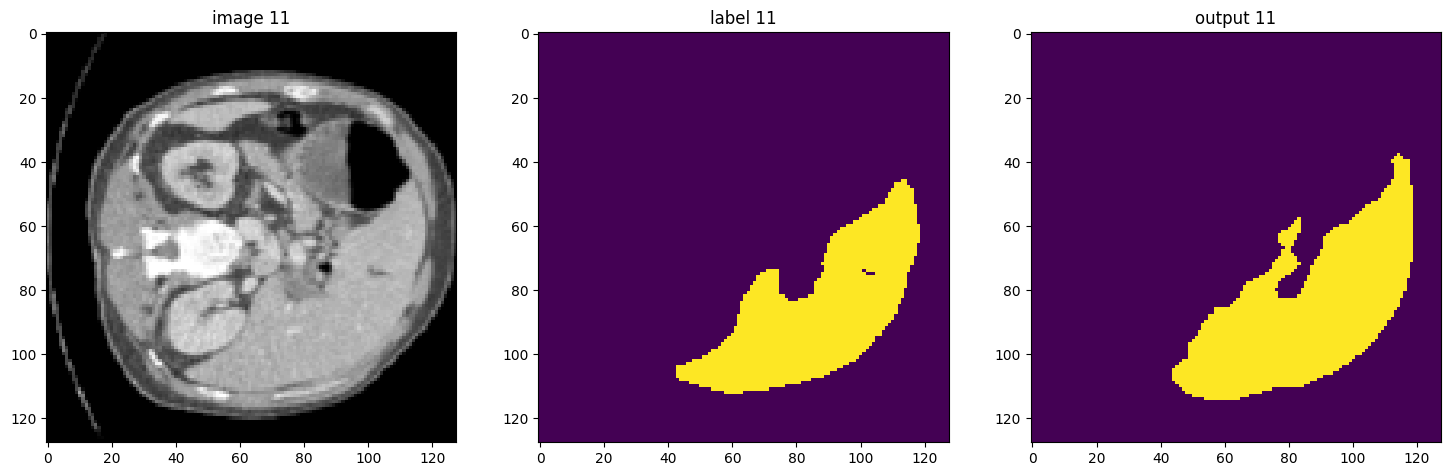

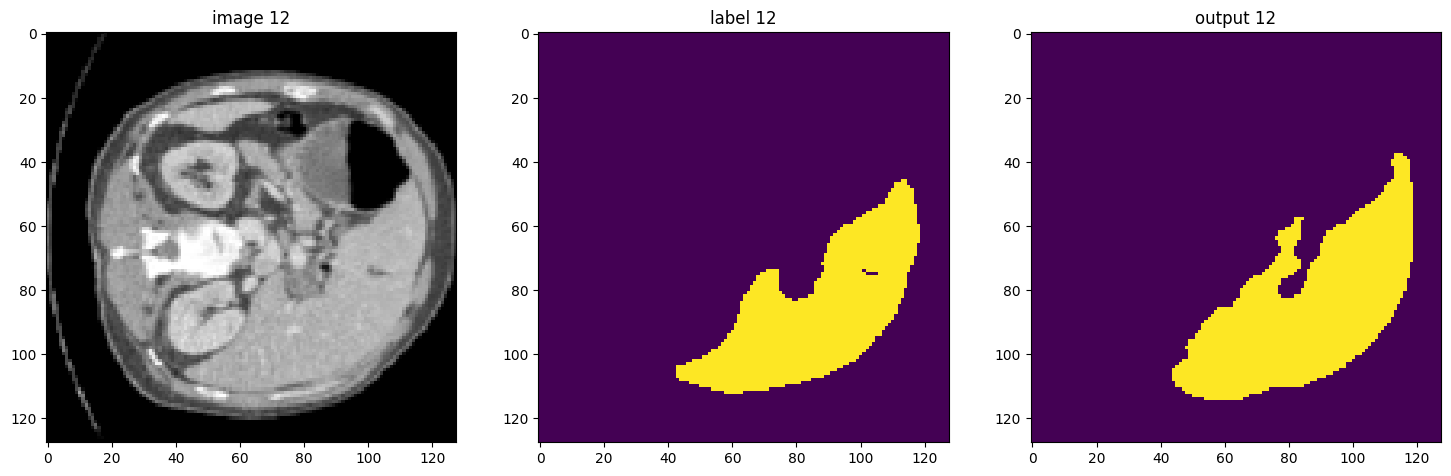

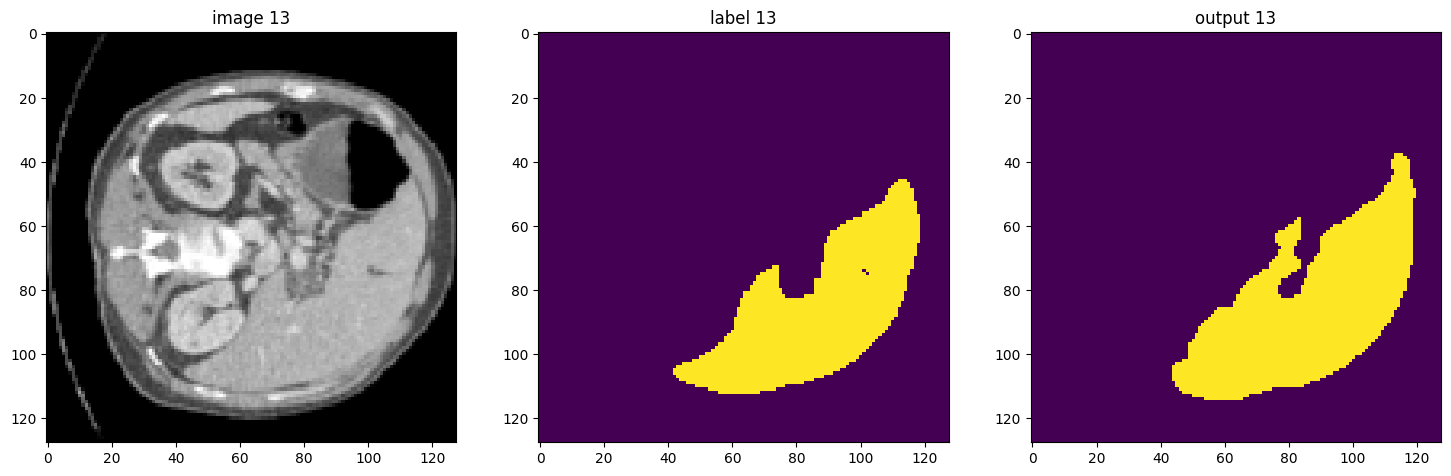

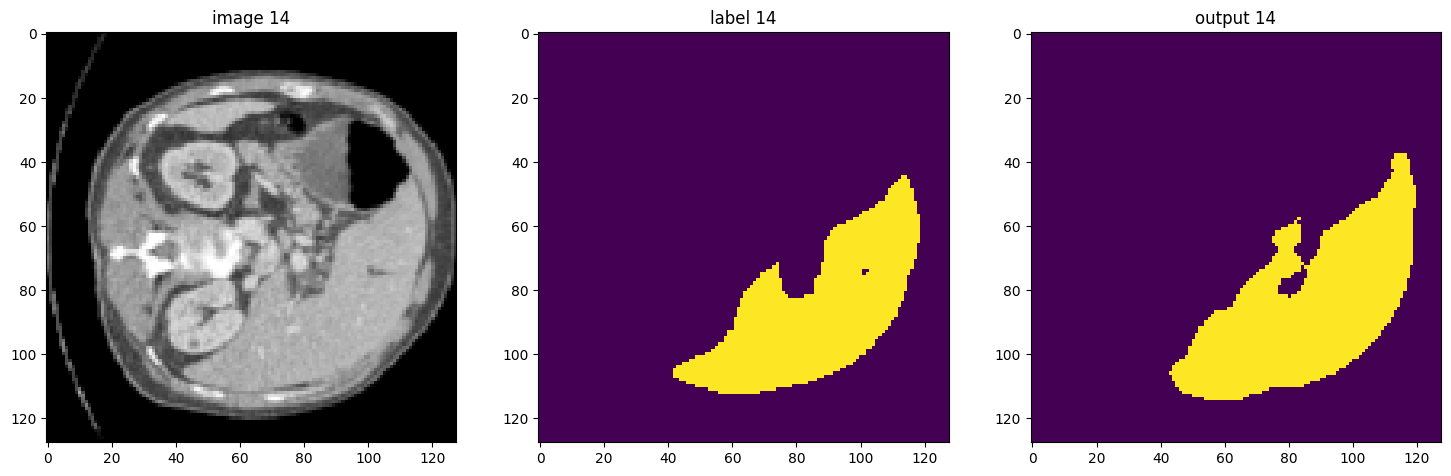

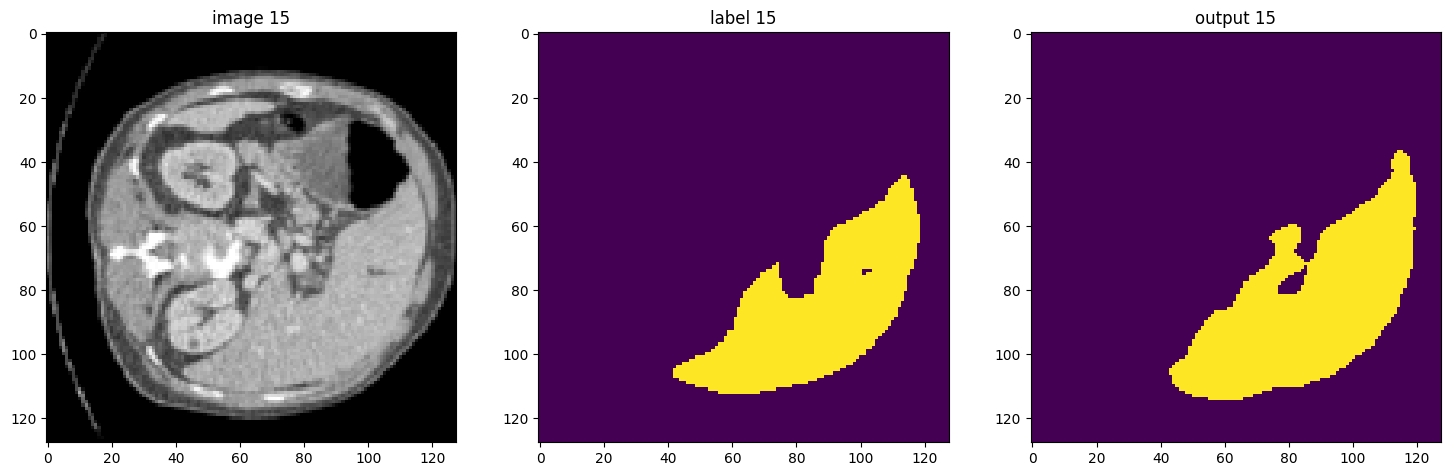

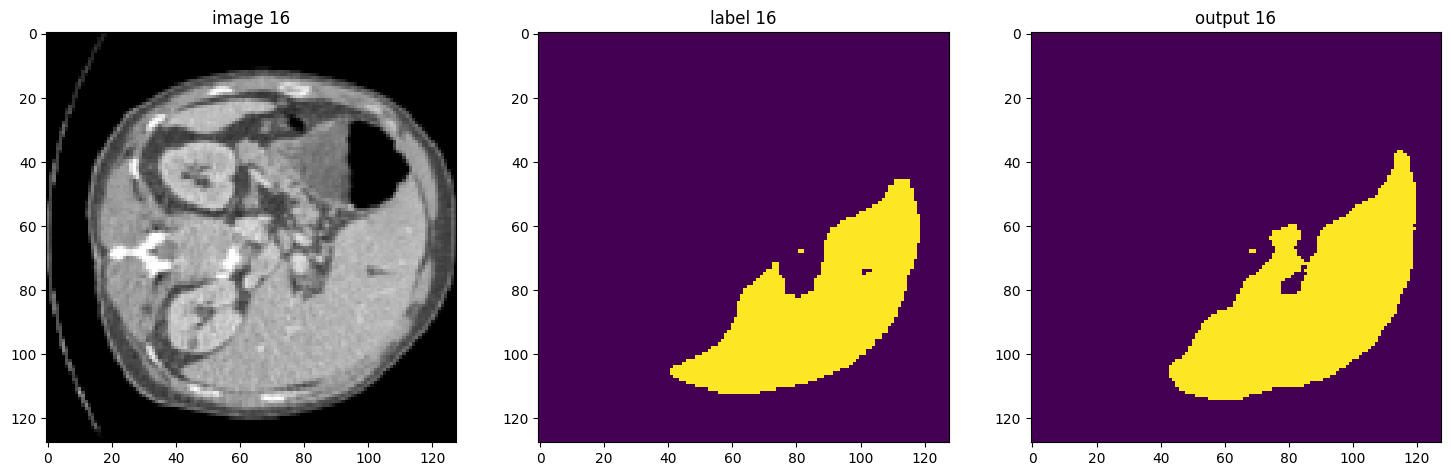

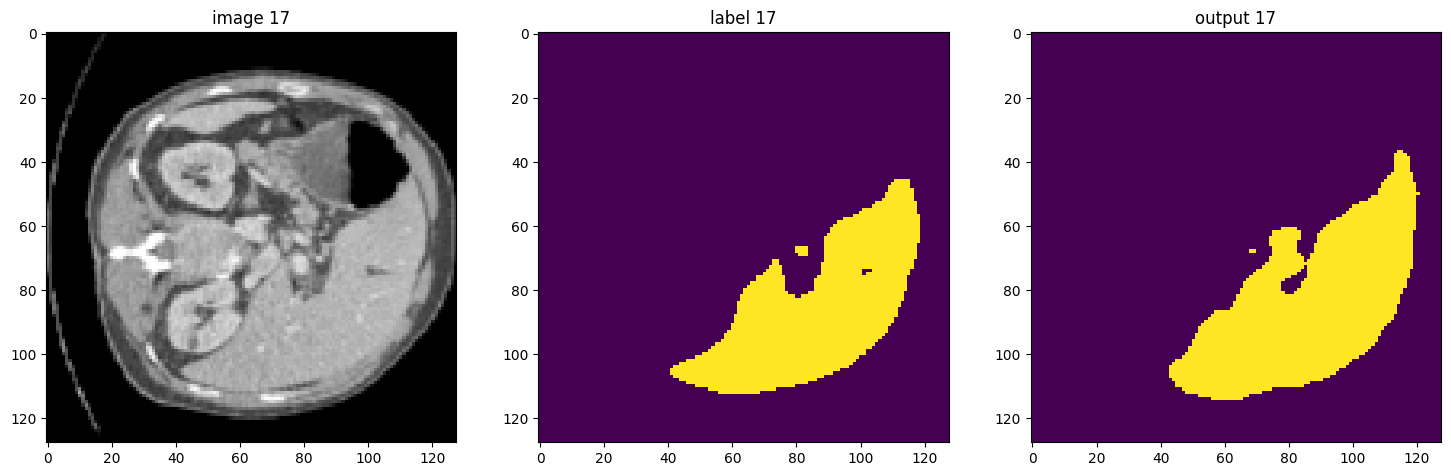

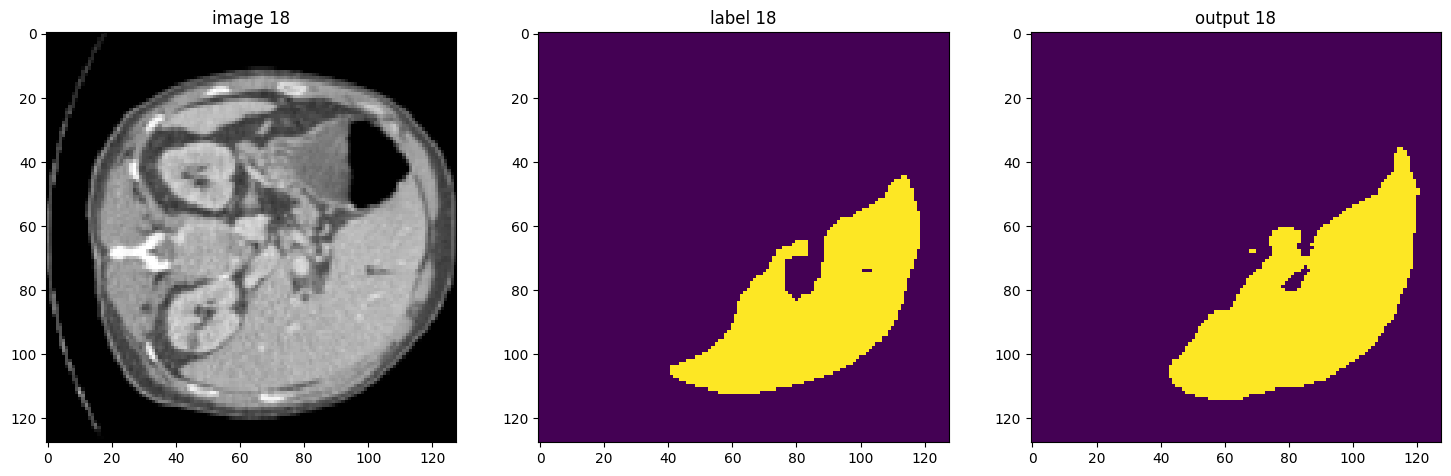

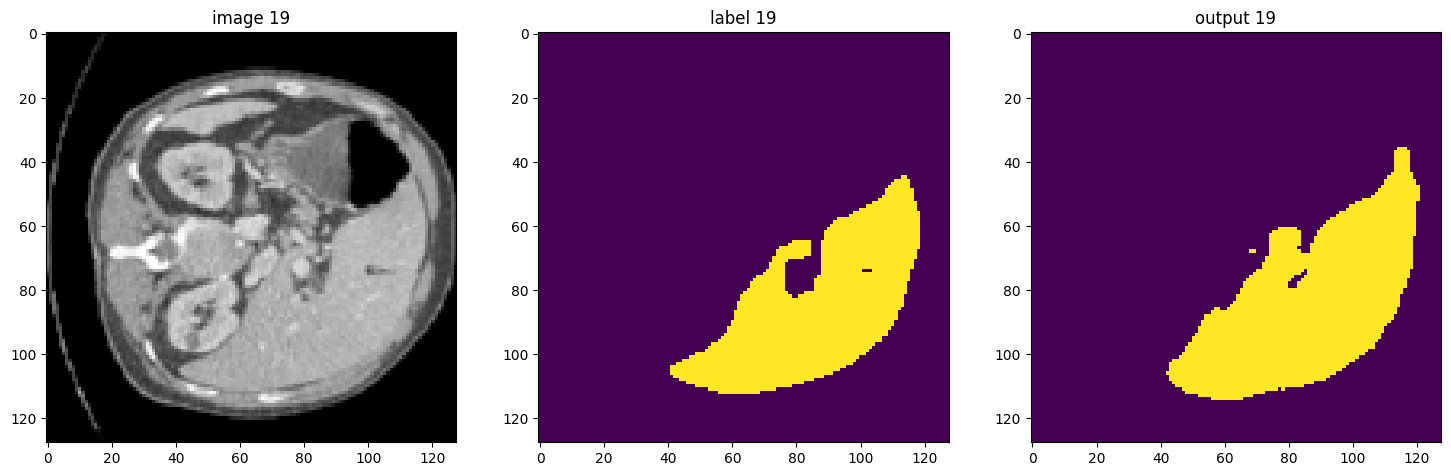

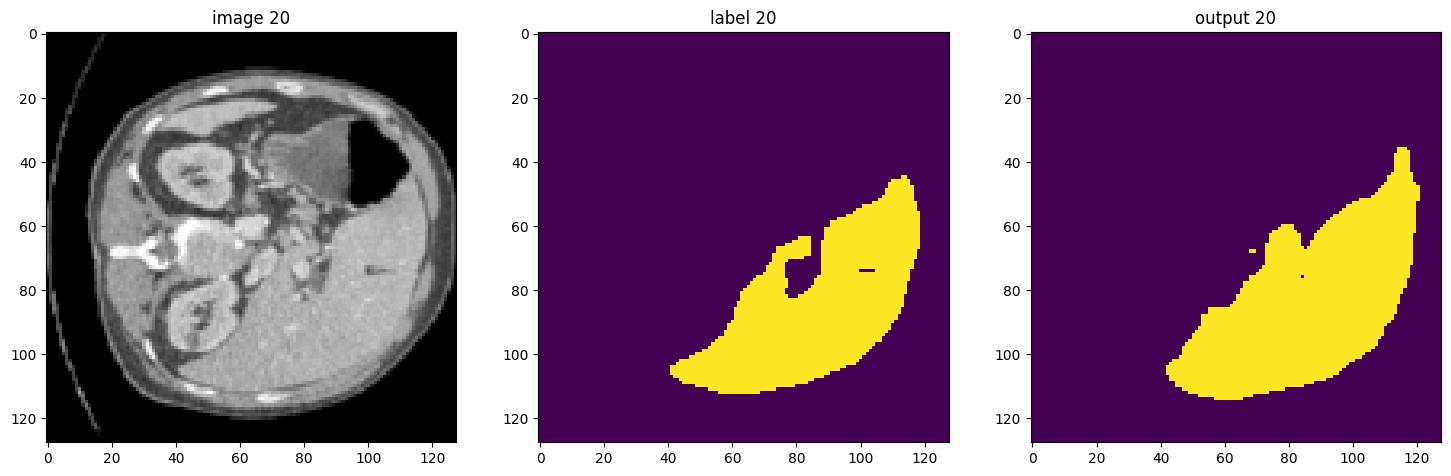

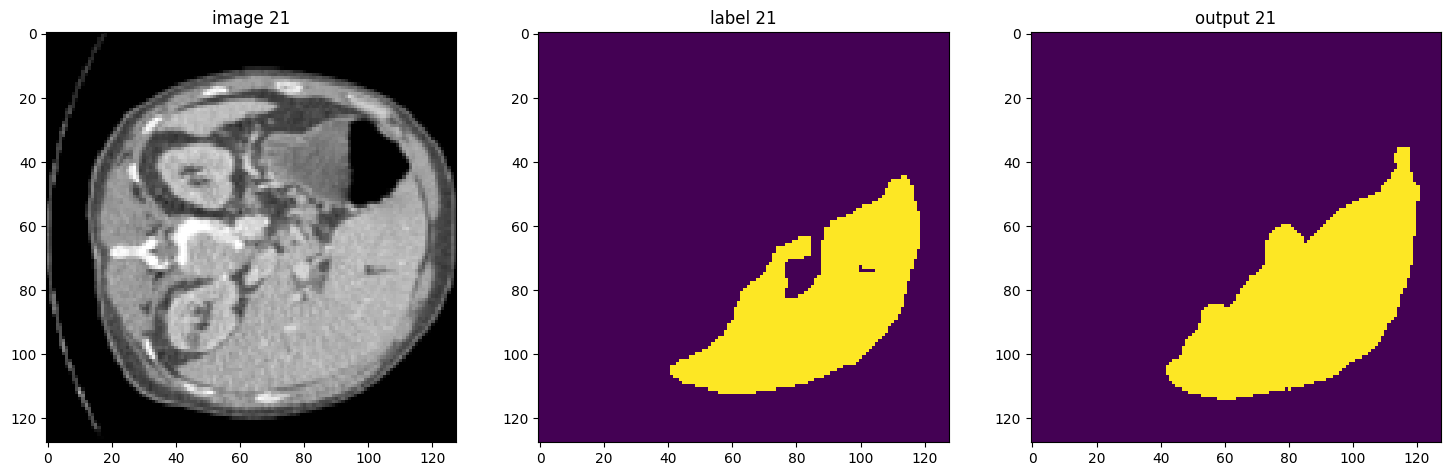

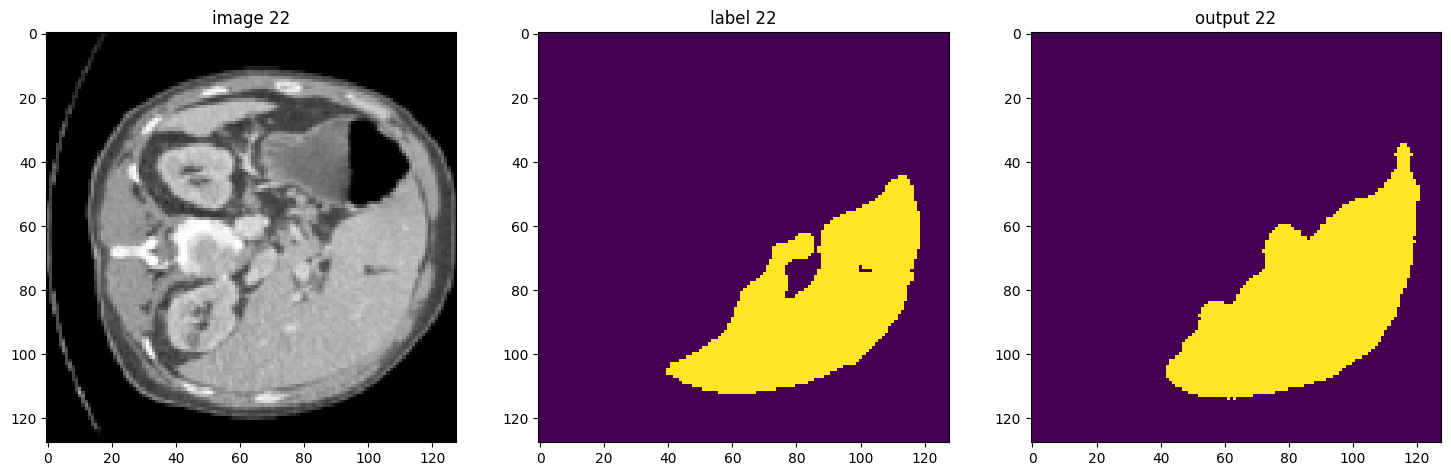

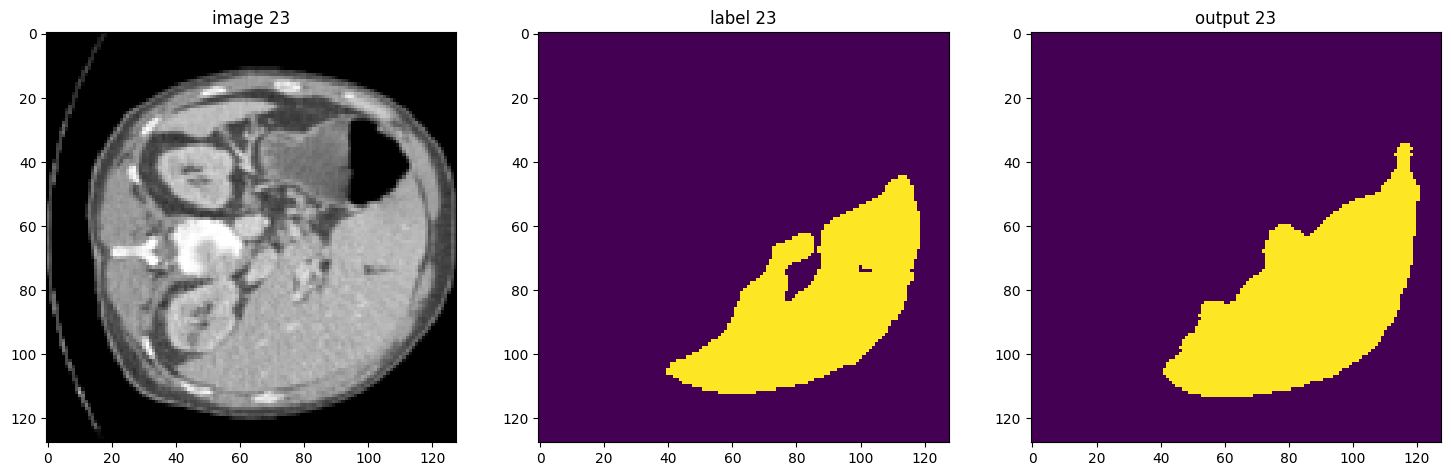

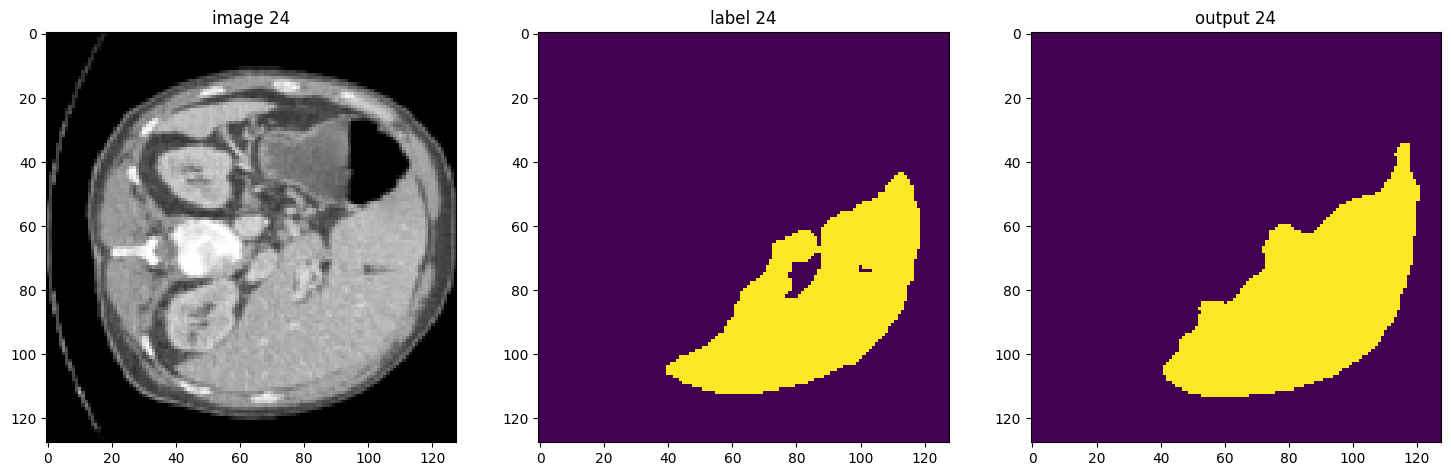

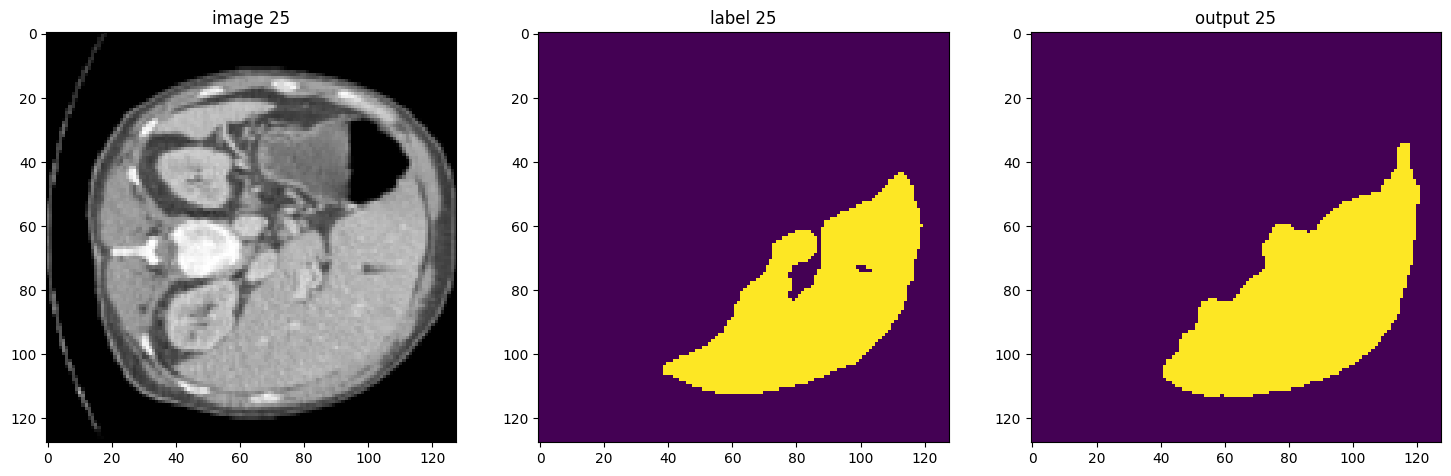

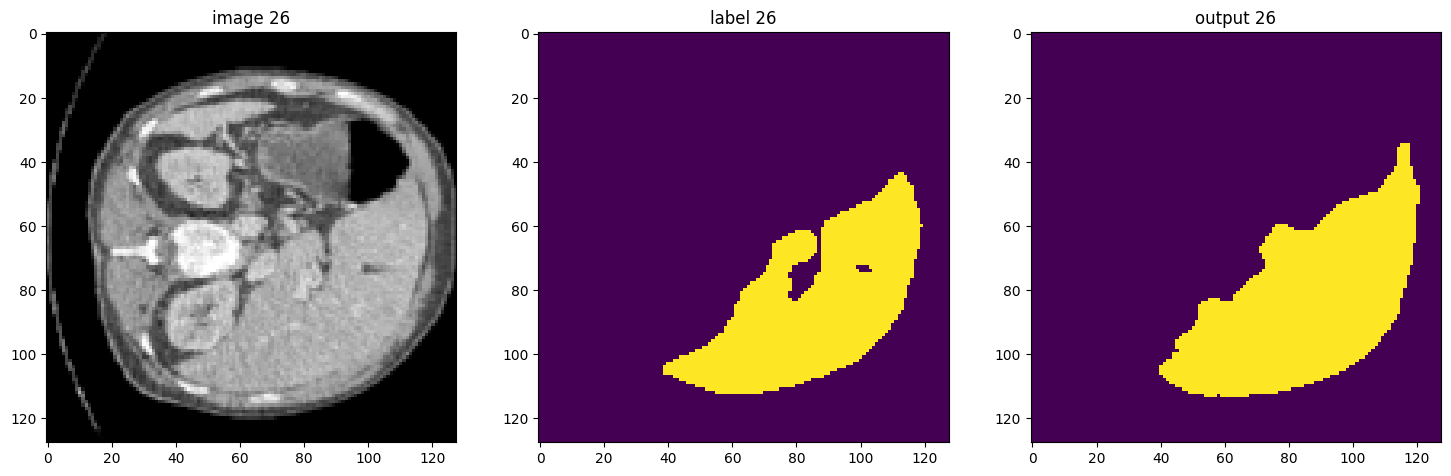

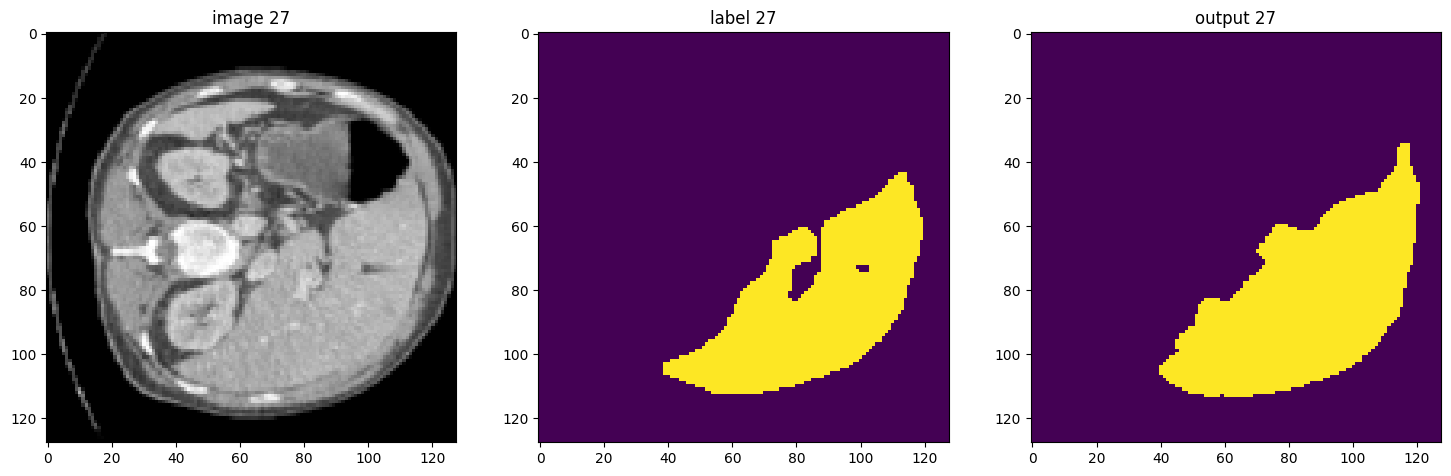

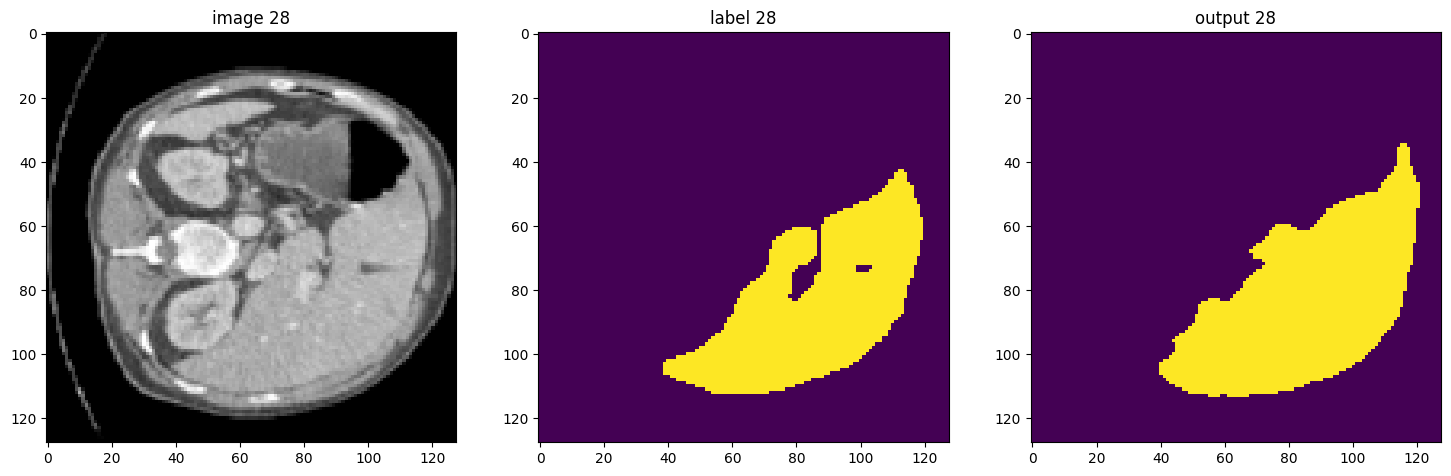

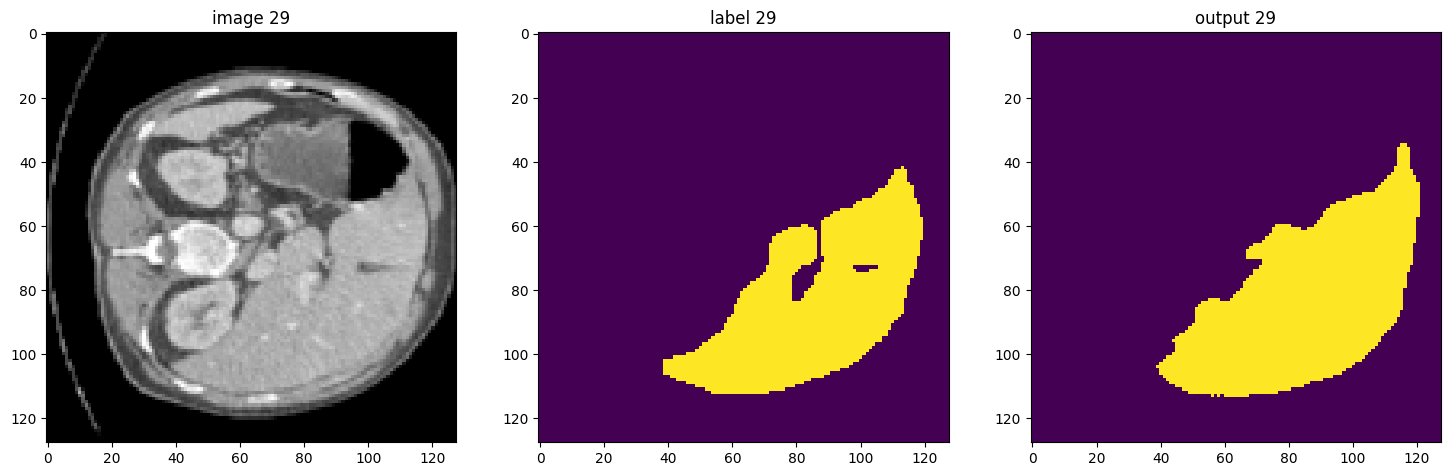

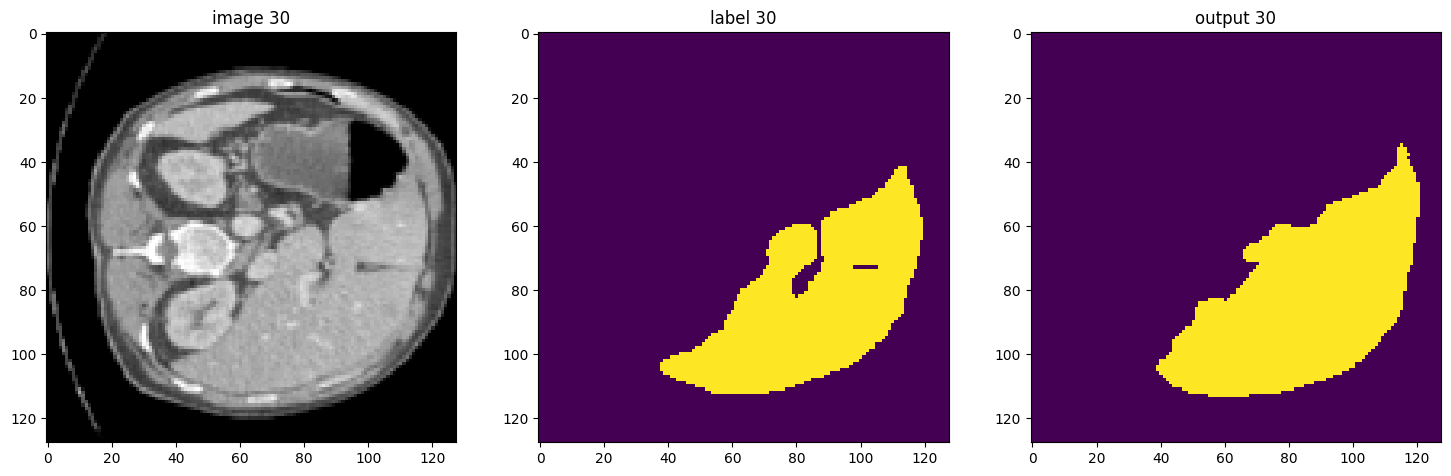

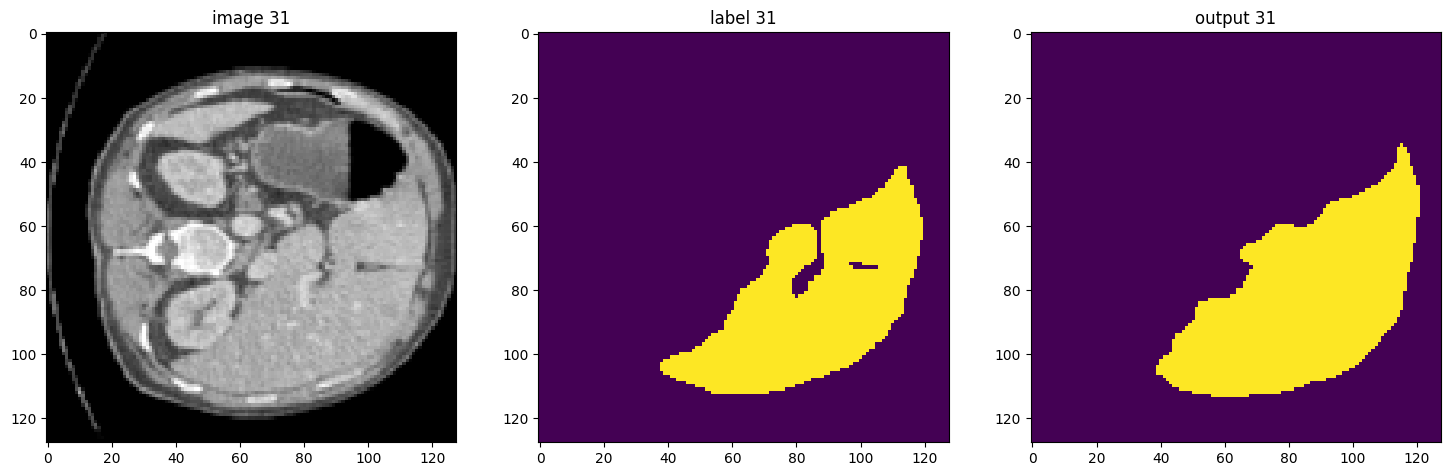

In [16]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

In [17]:
# ...existing code...

# Calculate accuracy and Jaccard index (IoU) for the first test patient
output = test_outputs.detach().cpu().numpy()
label = test_patient["seg"].cpu().numpy()
# Binarize label if needed
label = (label != 0).astype(np.uint8)
output = output.astype(np.uint8)

# Use only the foreground class (assuming output shape [B, C, H, W, D], C=2)
# You may need to adjust this if your output is different
pred = output[0, 1]  # foreground
gt = label[0, 0]     # ground truth

intersection = np.logical_and(pred, gt).sum()
union = np.logical_or(pred, gt).sum()
jaccard = intersection / union if union > 0 else 1.0

accuracy = (pred == gt).sum() / np.prod(gt.shape)

print(f"Accuracy: {accuracy:.4f}")
print(f"Jaccard Index (IoU): {jaccard:.4f}")

Accuracy: 0.9681
Jaccard Index (IoU): 0.8421


In [19]:
def calculate_dice_score(prediction, ground_truth):
    """Calculate how similar the AI's answer is to the correct answer"""
    # Move to CPU and convert to float
    pred = (prediction > 0.5).float().cpu()
    gt = (ground_truth != 0).float().cpu()
    
    # Calculate overlap
    intersection = (pred * gt).sum()
    total = pred.sum() + gt.sum()
    
    if total == 0:
        return 1.0  # Perfect if both are empty
    
    dice = (2.0 * intersection) / total
    return dice.item()

# Calculate the AI's grade
dice_score = calculate_dice_score(
    test_outputs[0, 1],  # AI's answer
    test_patient["seg"][0, 0]  # Correct answer
)

print("\n🎯 FINAL RESULTS:")
print("="*50)
print(f"🏆 AI's Dice Score: {dice_score:.3f}")
print(f"📊 AI's Grade: {dice_score*100:.1f}%")

# Give a report card comment
if dice_score > 0.9:
    print("🌟 EXCELLENT! AI performed amazingly well!")
elif dice_score > 0.8:
    print("👍 VERY GOOD! AI did a great job!")
elif dice_score > 0.7:
    print("👌 GOOD! AI performed well with room for improvement!")
elif dice_score > 0.6:
    print("🆗 OKAY! AI needs some more training!")
else:
    print("😬 NEEDS WORK! AI needs significant improvement!")

print("="*50)


🎯 FINAL RESULTS:
🏆 AI's Dice Score: 0.914
📊 AI's Grade: 91.4%
🌟 EXCELLENT! AI performed amazingly well!
